In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator , VectorIndexer,VectorAssembler,IndexToString
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics

import os
import numpy as np
from datetime import datetime
import array
import matplotlib.pyplot as plt

In [2]:
start = datetime.now()

In [3]:
spark = SparkSession.builder.appName("SQLFinalProject").config("spark.master", "local").getOrCreate()

In [4]:
folder_path="E:\\BigDataProject\\brazilian-ecommerce"
customers =spark.read.csv(os.path.join(folder_path,"olist_customers_dataset.csv"),header=True)
orderItems = spark.read.csv(os.path.join(folder_path,"olist_order_items_dataset.csv"),header=True)
orderPayments = spark.read.csv(os.path.join(folder_path,"olist_order_payments_dataset.csv"),header=True)
orderReviews = spark.read.csv(os.path.join(folder_path,"olist_order_reviews_dataset.csv"),header=True)
orders = spark.read.csv(os.path.join(folder_path,"olist_orders_dataset.csv"),header=True)
products = spark.read.csv(os.path.join(folder_path,"olist_products_dataset.csv"),header=True)
sellers = spark.read.csv(os.path.join(folder_path,"olist_sellers_dataset.csv"),header=True)


In [5]:
#customers.printSchema();

# number of customers and sellers in each city

get number of orders for each customer 

In [6]:
customersOrders=customers.join(orders,["customer_id"],"inner").drop("order_purchase_timestamp","order_approved_at","order_delivered_carrier_date"
                ,"order_delivered_customer_date","order_estimated_delivery_date")
#print("customersOrders rows number: ",customersOrders.count());


cutomersOrders_OrdersCount= customersOrders.groupBy(col("customer_unique_id")).agg(count("customer_id"\
                        )).withColumnRenamed("count(customer_id)","orders_count").join(customersOrders,"customer_unique_id")
cutomersOrders_OrdersCount=cutomersOrders_OrdersCount.drop("customer_zip_code_prefix","customer_state","order_status")

"""
#show number of orders for each customer
print("cutomersOrders_OrdersCount rows count: ",cutomersOrders_OrdersCount.count())
cutomersOrders_OrdersCount.printSchema()
cutomersOrders_OrdersCount.sort().show()
#cutomersOrders_OrdersCount.printSchema()
"""

'\n#show number of orders for each customer\nprint("cutomersOrders_OrdersCount rows count: ",cutomersOrders_OrdersCount.count())\ncutomersOrders_OrdersCount.printSchema()\ncutomersOrders_OrdersCount.sort().show()\n#cutomersOrders_OrdersCount.printSchema()\n'

### Number of customers in each city

In [7]:

customersOrders_OrdersCount_cityCount = cutomersOrders_OrdersCount.groupBy(col("customer_city"\
        )).agg(count("customer_unique_id")).withColumnRenamed("count(customer_unique_id)","customer_city_count"\
        ).join(cutomersOrders_OrdersCount,"customer_city");
print("cutomersOrders_OrdersCount_cityCount rows count: ",customersOrders_OrdersCount_cityCount.count());
#customersOrders_OrdersCount_cityCount.printSchema();
#Show # of customers in each city
customersOrders_OrdersCount_cityCountShow= customersOrders_OrdersCount_cityCount.select(\
                 "customer_city","customer_city_count").distinct().sort(col("customer_city_count").desc())\
                                .limit(20);
#save number of users in each city
#customersOrders_OrdersCount_cityCountShow.coalesce(1).write.format("csv").option("header",True).save("E:/BigDataProject/MyTables/customersOrders_OrdersCount_cityCount_python.csv");
customersOrders_OrdersCount_cityCountShow.show();


"""
#Show highest 20 customer cities
#draw the result
y=np.asarray(customersOrders_OrdersCount_cityCountShow.select("customer_city_count").collect()).flatten()
x=np.asarray(customersOrders_OrdersCount_cityCountShow.select("customer_city").collect()).flatten()


plt.bar(x ,y)
plt.title("Customer in each city")
plt.ylabel("Customer count")
plt.xlabel("Customer City")
plt.show()"""

cutomersOrders_OrdersCount_cityCount rows count:  99441
+--------------------+-------------------+
|       customer_city|customer_city_count|
+--------------------+-------------------+
|           sao paulo|              15540|
|      rio de janeiro|               6882|
|      belo horizonte|               2773|
|            brasilia|               2131|
|            curitiba|               1521|
|            campinas|               1444|
|        porto alegre|               1379|
|            salvador|               1245|
|           guarulhos|               1189|
|sao bernardo do c...|                938|
|             niteroi|                849|
|         santo andre|                797|
|              osasco|                746|
|              santos|                713|
|             goiania|                692|
| sao jose dos campos|                691|
|           fortaleza|                654|
|            sorocaba|                633|
|              recife|                613

'\n#Show highest 20 customer cities\n#draw the result\ny=np.asarray(customersOrders_OrdersCount_cityCountShow.select("customer_city_count").collect()).flatten()\nx=np.asarray(customersOrders_OrdersCount_cityCountShow.select("customer_city").collect()).flatten()\n\n\nplt.bar(x ,y)\nplt.title("Customer in each city")\nplt.ylabel("Customer count")\nplt.xlabel("Customer City")\nplt.show()'

### Number of seller in each city 

In [8]:
#show # of sellers for each city
SellerCities=sellers.groupBy(col("seller_city")).agg(count("seller_id")).withColumnRenamed("count(seller_id)","seller_city_count");
print("SellerCities rows count: ",SellerCities.count());
#SellerCities.printSchema()
SellerCitiesShow=SellerCities.select("seller_city","seller_city_count").distinct().sort(col("seller_city_count").desc()).limit(20);
#save number of sellers in each city
#SellerCitiesShow.coalesce(1).write.format("csv").option("header",True).save("E:/BigDataProject/MyTables/sellersCities_python.csv");
SellerCitiesShow.show();
"""
y=np.asarray(SellerCitiesShow.select("seller_city_count").collect()).flatten()
x=np.asarray(SellerCitiesShow.select("seller_city").collect()).flatten()
plt.bar(x ,y)
plt.title("Seller in each city")
plt.ylabel("Seller count")
plt.xlabel("Seller City")
plt.show()"""

SellerCities rows count:  611
+--------------------+-----------------+
|         seller_city|seller_city_count|
+--------------------+-----------------+
|           sao paulo|              694|
|            curitiba|              127|
|      rio de janeiro|               96|
|      belo horizonte|               68|
|      ribeirao preto|               52|
|           guarulhos|               50|
|            ibitinga|               49|
|         santo andre|               45|
|            campinas|               41|
|             maringa|               40|
|sao jose do rio p...|               33|
|              osasco|               32|
|sao bernardo do c...|               32|
|            sorocaba|               32|
|        porto alegre|               28|
|            brasilia|               28|
|            londrina|               26|
|             goiania|               23|
|           joinville|               22|
|            blumenau|               21|
+--------------------+-----

'\ny=np.asarray(SellerCitiesShow.select("seller_city_count").collect()).flatten()\nx=np.asarray(SellerCitiesShow.select("seller_city").collect()).flatten()\nplt.bar(x ,y)\nplt.title("Seller in each city")\nplt.ylabel("Seller count")\nplt.xlabel("Seller City")\nplt.show()'

## number of orders from each category in each city

In [9]:
customerId=customers.select("customer_id","customer_city")
orders_customerId=orders.join(customerId,["customer_id"],"inner").drop("order_status",\
                            "order_purchase_timestamp","order_approved_at","order_delivered_carrier_date"\
                            ,"order_delivered_customer_date","order_estimated_delivery_date")
#print(orders_customerId.count())
#orders_customerId.printSchema()

orders_customerId_orderItems=orders_customerId.join(orderItems,["order_id"],"inner").drop(\
                                               "shipping_limit_date","price","freight_value")
#print(orders_customerId_orderItems.count())
#orders_customerId_orderItems.printSchema()
#print(orders_customerId_orderItems.select("order_id").distinct().count())

orders_customerId_orderItems_products=orders_customerId_orderItems.join(products,["product_id"],"inner").drop(\
                                    "product_name_lenght","product_description_lenght","product_photos_qty",\
                                    "product_weight_g","product_length_cm","product_height_cm","product_width_cm")
#print(orders_customerId_orderItems_products.count())
#orders_customerId_orderItems_products.printSchema()
#orders_customerId_orderItems_products.show()

orders_customerId_orderItems_products=orders_customerId_orderItems.join(products,["product_id"],"inner").drop("product_name_lenght"\
                                    ,"product_description_lenght","product_photos_qty","product_weight_g","product_length_cm"\
                                    ,"product_height_cm","product_width_cm")
#print(orders_customerId_orderItems_products.count())
#orders_customerId_orderItems_products.printSchema()
#print(orders_customerId_orderItems_products.select("order_id").distinct().count())
#orders_customerId_orderItems_products.show()

o=orders_customerId_orderItems_products.select("customer_city","product_category_name")
category= o.select("product_category_name").distinct()
print(category.count())
print("schema of table to count number of orders of each category from each city")
orders_customerId_orderItems_products.printSchema()
#print("number of records",orders_customerId_orderItems_products.count())


product_category_name_orderId=orders_customerId_orderItems_products.groupBy("customer_city","product_category_name").agg(count("product_category_name"),\
                                                                                            count("customer_city")).drop("count(customer_city)")


product_category_name_orderId=product_category_name_orderId.sort(col("count(product_category_name)").desc())
#product_category_name_orderId_show=product_category_name_orderId.filter("product_category_name= 'cama_mesa_banho'").coalesce(1).write.format("csv"\
 #                                 ).option("header",True).save("E:/BigDataProject/MyTables/category_customer_python.csv");
product_category_name_orderId.show(50)
print("----------------------------------------\n")
product_category_name_orderId_show=product_category_name_orderId.filter("product_category_name= 'cama_mesa_banho'").limit(20)
print("number of sellers for cama_mesa_banho category ")
product_category_name_orderId_show.show()
"""
#show number of sellers for cama_mesa_banho category
y=np.asarray(product_category_name_orderId_show.select("count(product_category_name)").collect()).flatten()
x=np.asarray(product_category_name_orderId_show.select("customer_city").collect()).flatten()
plt.bar(x ,y)
plt.title("ordered product of category from each city")
plt.ylabel("Seller count")
plt.xlabel("Seller City")
plt.show()                                                                                                         
"""                                                                                                 

74
schema of table to count number of orders of each category from each city
root
 |-- product_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- order_item_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)

+--------------+---------------------+----------------------------+
| customer_city|product_category_name|count(product_category_name)|
+--------------+---------------------+----------------------------+
|     sao paulo|      cama_mesa_banho|                        1984|
|     sao paulo|         beleza_saude|                        1753|
|     sao paulo|        esporte_lazer|                        1397|
|     sao paulo| utilidades_domest...|                        1321|
|     sao paulo|     moveis_decoracao|                        1268|
|     sao paulo| informatica_acess...|                        12

'\n#show number of sellers for cama_mesa_banho category\ny=np.asarray(product_category_name_orderId_show.select("count(product_category_name)").collect()).flatten()\nx=np.asarray(product_category_name_orderId_show.select("customer_city").collect()).flatten()\nplt.bar(x ,y)\nplt.title("ordered product of category from each city")\nplt.ylabel("Seller count")\nplt.xlabel("Seller City")\nplt.show()                                                                                                         \n'

In [10]:
#product_category_name_orderId.filter("customer_city = 'sao paulo'").coalesce(1).write.format("csv").option("header",True).save("E:/BigDataProject/MyTables/category_customer_sao_paulo.csv");

## sao paulo analysis

### category does not have seller in sao paulo

get number of sellers for each category

In [11]:
p=products.select('product_id','product_category_name')
result=orderItems.join(sellers,['seller_id'],'inner').drop('shipping_limit_date',\
                    'price','freight_value','seller_zip_code_prefix','seller_zip_code_prefix'\
                    ).join(p,['product_id'],'inner').filter("seller_city ='sao paulo'")


result=result.select("seller_id","seller_city","product_category_name").distinct().groupBy(\
                    "product_category_name","seller_city").agg(count("seller_id").alias("sellers_number"),count(\
                     "seller_id")).drop("count(seller_id)")
result.sort(col("sellers_number").desc()).show()
#result.groupBy("seller_city").agg(sum("sellers_number")).show()
#result.show()

+---------------------+-----------+--------------+
|product_category_name|seller_city|sellers_number|
+---------------------+-----------+--------------+
|         beleza_saude|  sao paulo|           119|
|        esporte_lazer|  sao paulo|           114|
| utilidades_domest...|  sao paulo|           112|
|     moveis_decoracao|  sao paulo|            82|
|           automotivo|  sao paulo|            81|
| informatica_acess...|  sao paulo|            66|
|           cool_stuff|  sao paulo|            65|
|           brinquedos|  sao paulo|            61|
|   ferramentas_jardim|  sao paulo|            59|
|                bebes|  sao paulo|            57|
|            telefonia|  sao paulo|            51|
|                 null|  sao paulo|            51|
|           perfumaria|  sao paulo|            43|
|            papelaria|  sao paulo|            41|
|          eletronicos|  sao paulo|            40|
|      cama_mesa_banho|  sao paulo|            39|
| construcao_ferram...|  sao pa

categories doesn't have seller in sao paulo

In [12]:
#filter the sao paulo sellers
sao_paulo_sellers=sellers.filter("seller_city = 'sao paulo'")
#orders_customerId_orderItems_products.printSchema()


#know the categories that have sellers in sao paul sell them
sao_paulo=sao_paulo_sellers.join(orders_customerId_orderItems_products,["seller_id"],"inner")

sao_paulo=sao_paulo.select("seller_id","seller_city","product_category_name").distinct()
#sao_paulo.printSchema()
sao_paulo.show()

#show number of sellers for each category in sao paulo
sao_paulo_groupBy=sao_paulo.groupBy("product_category_name","seller_city").agg(count("seller_id").alias("sellers_count"),count("seller_city")).drop("count(seller_city)")
sao_paulo_groupBy=sao_paulo_groupBy.sort(col("sellers_count").desc())
sao_paulo_groupBy.show()

#how many sellers for all category
sao_paulo_groupBy.groupBy("seller_city").agg(sum("sellers_count")).show()

#right anit join
#categories doesn't have sellers in sao paulo 
c=sao_paulo_groupBy.join(category,["product_category_name"],"rightOuter").filter("seller_city is null AND product_category_name is not null")

#show the categoeies doesn't have sellers in sao paulo
print("category which has no sellers in sao paulo")
c.select("product_category_name").show()

#sao_paulo_groupBy.coalesce(1).write.format("csv").option("header",True).save("E:/BigDataProject/MyTables/sao_pa.csv");

+--------------------+-----------+---------------------+
|           seller_id|seller_city|product_category_name|
+--------------------+-----------+---------------------+
|955fee9216a65b617...|  sao paulo|   ferramentas_jardim|
|3bdff180c7e1f6551...|  sao paulo| informatica_acess...|
|6ddc28b61be28373b...|  sao paulo|           brinquedos|
|4ebdc7e6cd6102a02...|  sao paulo| utilidades_domest...|
|3935fe5fe0f82787a...|  sao paulo|           automotivo|
|7040e82f899a04d1b...|  sao paulo|                bebes|
|5f1dc28029d2c2443...|  sao paulo|     fashion_calcados|
|432c67955c0acd1fd...|  sao paulo|                 null|
|778323240ce2830d6...|  sao paulo|         beleza_saude|
|fa14641f57b655e93...|  sao paulo|            telefonia|
|508808d438fe2ff97...|  sao paulo| utilidades_domest...|
|891071be6ba827b59...|  sao paulo|        esporte_lazer|
|7e3f87d16fb353f40...|  sao paulo|           cool_stuff|
|b6f52e346160519c2...|  sao paulo|         beleza_saude|
|2e13c71026e1a39ba...|  sao pau

# Preferred payment way

In [13]:
#because the customer can pay by more than one method
order_payments_orderItems=orderPayments.drop("payment_sequential","payment_installments").join(orderItems,"order_id").drop("shipping_limit_date","price","freight_value")
payment_type=order_payments_orderItems.groupBy("payment_type").agg(count("order_id").alias("count_of_orders"))
payment_type = payment_type.sort(col("count_of_orders").desc())
payment_type.show()
#saveing the sresults
#payment_type.coalesce(1).write.format("csv").option("header",True).save("E:/BigDataProject/MyTables/payment_type.csv");
"""
#draw the result
y=np.asarray(payment_type.select("count_of_orders").collect()).flatten()
x=np.asarray(payment_type.select("payment_type").collect()).flatten()
#it doesn't matter the payement value,the users prefer credit_card to pay
print(type(y[0]))
type(x)
plt.bar(x ,y)
plt.title("Payment way")
plt.ylabel("Payment number")
plt.xlabel("Payment way")
plt.show()"""

+------------+---------------+
|payment_type|count_of_orders|
+------------+---------------+
| credit_card|          86769|
|      boleto|          22867|
|     voucher|           6274|
|  debit_card|           1691|
+------------+---------------+



'\n#draw the result\ny=np.asarray(payment_type.select("count_of_orders").collect()).flatten()\nx=np.asarray(payment_type.select("payment_type").collect()).flatten()\n#it doesn\'t matter the payement value,the users prefer credit_card to pay\nprint(type(y[0]))\ntype(x)\nplt.bar(x ,y)\nplt.title("Payment way")\nplt.ylabel("Payment number")\nplt.xlabel("Payment way")\nplt.show()'

# Orders Reviews select the category that get highest 5 review

In [14]:
c=customers.select("customer_id","customer_unique_id","customer_city")
o=orders.select("order_id","customer_id")
oI=orderItems.select("order_id","product_id")
p=products.select("product_id","product_category_name")
oR=orderReviews.select("review_id","order_id","review_score").join(oI,"order_id").join(p,"product_id")
oR=oR.na.drop().distinct()
o=oR.groupBy("product_category_name" ,"review_score" ).agg(count("review_score").alias("count_of_reviews"),count("order_id")).drop("count(order_id)")
o.sort(col("review_score").desc(),col("count_of_reviews").desc()).show()
#.sort(col("review_score").desc(),col("count_of_reviews").desc()).limit(30).coalesce(1).write.format("csv").option("header",True).save("E:/BigDataProject/MyTables/score_reviews")


+---------------------+------------+----------------+
|product_category_name|review_score|count_of_reviews|
+---------------------+------------+----------------+
|         beleza_saude|           5|            5541|
|      cama_mesa_banho|           5|            5311|
|        esporte_lazer|           5|            4750|
| informatica_acess...|           5|            3803|
|     moveis_decoracao|           5|            3765|
| utilidades_domest...|           5|            3529|
|   relogios_presentes|           5|            3277|
|           brinquedos|           5|            2448|
|           automotivo|           5|            2267|
|            telefonia|           5|            2243|
|           cool_stuff|           5|            2168|
|   ferramentas_jardim|           5|            2112|
|           perfumaria|           5|            2064|
|                bebes|           5|            1663|
|            papelaria|           5|            1477|
|          eletronicos|     


# Model to predict product category

In [15]:
spark = SparkSession.builder.appName("SQLFinalProject").config("spark.master", "local").getOrCreate()

In [16]:
p=products.groupBy("product_category_name").agg(count("product_id").alias("products_count"))

#print(classes_names)
#print("number of classes: ",p.count())
p=p.sort(col("products_count").desc())
p.show()

p=p.filter(col("products_count")>=2000)
classes_names=np.asarray(p.select("product_category_name").collect())

data=p.join(products,["product_category_name"],"inner").drop("products_count","product_id")
data.dtypes

+---------------------+--------------+
|product_category_name|products_count|
+---------------------+--------------+
|      cama_mesa_banho|          3029|
|        esporte_lazer|          2867|
|     moveis_decoracao|          2657|
|         beleza_saude|          2444|
| utilidades_domest...|          2335|
|           automotivo|          1900|
| informatica_acess...|          1639|
|           brinquedos|          1411|
|   relogios_presentes|          1329|
|            telefonia|          1134|
|                bebes|           919|
|           perfumaria|           868|
|            papelaria|           849|
| fashion_bolsas_e_...|           849|
|           cool_stuff|           789|
|   ferramentas_jardim|           753|
|             pet_shop|           719|
|                 null|           610|
|          eletronicos|           517|
| construcao_ferram...|           400|
+---------------------+--------------+
only showing top 20 rows



[('product_category_name', 'string'),
 ('product_name_lenght', 'string'),
 ('product_description_lenght', 'string'),
 ('product_photos_qty', 'string'),
 ('product_weight_g', 'string'),
 ('product_length_cm', 'string'),
 ('product_height_cm', 'string'),
 ('product_width_cm', 'string')]

In [17]:
#drop row containing null
data=data.na.drop()
data.count()

13332

In [18]:
#preparing dataset
categoricalColumns = ['product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'product_category_name', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = [c + "classVec" for c in categoricalColumns] 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
print(stages)

[StringIndexer_124217066559, OneHotEncoderEstimator_c6dd736883af, StringIndexer_9acf814da5cc, OneHotEncoderEstimator_51c8114439d8, StringIndexer_e6c8027fd4f6, OneHotEncoderEstimator_f7e558f6c111, StringIndexer_91fac27d2613, OneHotEncoderEstimator_b5f01a3152a6, StringIndexer_b1d842202867, OneHotEncoderEstimator_62a3cb8056f8, StringIndexer_c6f800b61cea, OneHotEncoderEstimator_5e0226db68e3, StringIndexer_03b24764ae76, OneHotEncoderEstimator_db02aab74a52, StringIndexer_9fe24333aefa, VectorAssembler_7f6c3a7ffc72]


In [19]:
#use pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
cols = data.columns
df = pipelineModel.transform(data)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: string (nullable = true)
 |-- product_description_lenght: string (nullable = true)
 |-- product_photos_qty: string (nullable = true)
 |-- product_weight_g: string (nullable = true)
 |-- product_length_cm: string (nullable = true)
 |-- product_height_cm: string (nullable = true)
 |-- product_width_cm: string (nullable = true)



### Divide the total dataset into 9/1

In [20]:
train, test = df.randomSplit([0.9, 0.1], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 11996
Test Dataset Count: 1336


### train and test the model

In [21]:
train.cache()
test.cache()

lr = LogisticRegression(maxIter=60, regParam=0.1)
lrModel = lr.fit(train)
result=lrModel.transform(test)
predictionAndLabels=result.select("label","prediction").rdd


### evaluate the training 

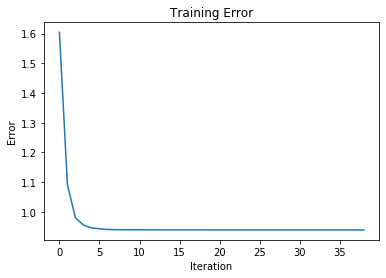

'\n#print("objectiveHistory:")\nfor objective in objectiveHistory:\n    print(objective)\n'

In [22]:
trainingSummary = lrModel.summary

# Obtain the objective per iteration "error in each iteration"
objectiveHistory = trainingSummary.objectiveHistory

plt.plot(objectiveHistory)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.title("Training Error")
plt.show()
"""
#print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)
"""

Precision by label:


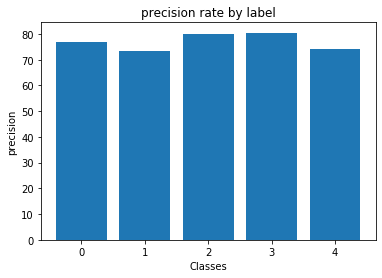

Recall by label:


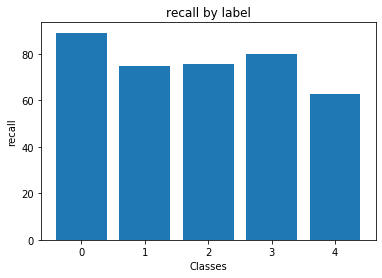

F-measure by label:


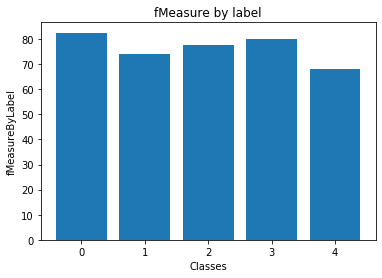

Accuracy: 0.7702567522507503
F-measure: 0.768166160728603
Precision: 0.770090027910814
Recall: 0.7702567522507503


In [25]:
# for multiclass, we can inspect metrics on a per-label basis
"""
print("False positive rate by label:")
i_arr=[i for i in range(len(classes_names))]
f_p_rate_arr=[rate*100 for  rate in trainingSummary.falsePositiveRateByLabel]

for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

plt.bar(i_arr ,f_p_rate_arr)
plt.title("False positive rate by label")
plt.ylabel("False positive")
plt.xlabel("Classes")
plt.show()


print("True positive rate by label:")
t_p_rate_arr=[rate*100 for  rate in trainingSummary.truePositiveRateByLabel]


plt.bar(i_arr ,t_p_rate_arr)
plt.title("True positive rate by label")
plt.ylabel("True positive")
plt.xlabel("Classes")
plt.show()


for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))
    
"""

print("Precision by label:")
i_arr=[i for i in range(len(classes_names))]
p_arr=[rate*100 for  rate in trainingSummary.precisionByLabel]
plt.bar(i_arr ,p_arr)
plt.title("precision rate by label")
plt.ylabel("precision")
plt.xlabel("Classes")
plt.show()

"""
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))
"""
print("Recall by label:")
r_arr=[rate*100 for  rate in trainingSummary.recallByLabel]
plt.bar(i_arr ,r_arr)
plt.title("recall by label")
plt.ylabel("recall")
plt.xlabel("Classes")
plt.show()

"""
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))
"""
print("F-measure by label:")
f_arr=[rate*100 for  rate in trainingSummary.fMeasureByLabel()]
plt.bar(i_arr ,f_arr)
plt.title("fMeasure by label")
plt.ylabel("fMeasureByLabel")
plt.xlabel("Classes")
plt.show()
"""
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))
"""    
    
    
    
accuracy = trainingSummary.accuracy
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, fMeasure, precision, recall))

### evaluate the trained model during test

In [26]:

#predictionAndLabels = test.map(lambda lp: (float(lrModel.predict(lp.features)), lp.label))
metrics = MulticlassMetrics(predictionAndLabels)
ac=metrics.accuracy
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = ", precision)
print("Recall = ", recall)
print("F Meaure = ", f1Score)
print("Accuracy = ",ac)

Summary Stats
Precision =  0.5202095808383234
Recall =  0.5202095808383234
F Meaure =  0.5202095808383234
Accuracy =  0.5202095808383234


In [27]:

converter = IndexToString(inputCol="label", outputCol="originalCategory")
converted = converter.transform(result)

converted.select("label","originalCategory").distinct().sort(col("label").asc()).show()


+-----+--------------------+
|label|    originalCategory|
+-----+--------------------+
|  0.0|     cama_mesa_banho|
|  1.0|       esporte_lazer|
|  2.0|    moveis_decoracao|
|  3.0|        beleza_saude|
|  4.0|utilidades_domest...|
+-----+--------------------+



In [28]:
end = datetime.now()
run_time=end-start
print("Total run time: ",run_time)

Total run time:  0:09:44.073408
